In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch
import chess.pgn
from stockfish import Stockfish
import sqlite3
import chess

In [2]:
torch.cuda.set_device(0)
device = torch.device('cuda')
loss_function = nn.MSELoss()

In [3]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(768, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Linear(2048, 1),
        )
    def forward(self, x):
        return self.layers(x)

In [4]:
model = Model()
# model = torch.load("muthubotv2.pt")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model.to(device)

Model(
  (layers): Sequential(
    (0): Linear(in_features=768, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=2048, bias=True)
    (4): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=2048, out_features=1, bias=True)
  )
)

In [60]:
def fen_to_bitboard(fen):
    f = torch.zeros((12, 64))
    board = chess.Board(fen)
    if board.turn == chess.WHITE:
        a = 1
        b = -1
    if board.turn == chess.BLACK:
        a = -1
        b = 1
    f[0][list(board.pieces(chess.PAWN, chess.WHITE))] = a
    f[1][list(board.pieces(chess.KNIGHT, chess.WHITE))] = a
    f[2][list(board.pieces(chess.ROOK, chess.WHITE))] = a
    f[3][list(board.pieces(chess.BISHOP, chess.WHITE))] = a
    f[4][list(board.pieces(chess.QUEEN, chess.WHITE))] = a
    f[5][list(board.pieces(chess.KING, chess.WHITE))] = a
    
    f[6][list(board.pieces(chess.PAWN, chess.BLACK))] = b
    f[7][list(board.pieces(chess.KNIGHT, chess.BLACK))] = b
    f[8][list(board.pieces(chess.ROOK, chess.BLACK))] = b
    f[9][list(board.pieces(chess.BISHOP, chess.BLACK))] = b
    f[10][list(board.pieces(chess.QUEEN, chess.BLACK))] = b
    f[11][list(board.pieces(chess.KING, chess.BLACK))] = b
    
    return f.view(1, 768)

In [6]:
con = sqlite3.connect('test.db')
cur = con.cursor()

In [11]:
size = 1000000
# training dataset
# fens_ = cur.execute(f"SELECT fen FROM evaluations LIMIT {size}")
# fens = fens_.fetchall()
# tensors = [fen_to_bitboard(fens[i][0]) for i in range(size)]
# bits = torch.cat(tensors, dim=0)
# with open('bits.npy', 'wb') as f:
#     np.save(f, bits)

# evals_ = cur.execute(f"SELECT eval FROM evaluations LIMIT {size}")
# evals = evals_.fetchall()
# temp = [((np.arctan(1/2 * evals[i][0]) + np.pi/2)/(np.pi)) for i in range(size)]
# evaluations = torch.tensor(temp, dtype=torch.float32)
# with open('labels.npy', 'wb') as f:
#     np.save(f, evaluations)


# evaluation dataset
eval_size = 10000
e_fen_ = cur.execute(f"SELECT fen FROM evaluations WHERE id > {size} LIMIT {eval_size}")
e_fen = e_fen_.fetchall()
tensors = [fen_to_bitboard(e_fen[i][0]) for i in range(eval_size)]
bits = torch.cat(tensors, dim=0)
with open('eval_examples.npy', 'wb') as f:
    np.save(f, bits)

evaluation_ = cur.execute(f"SELECT eval FROM evaluations WHERE id > {size} LIMIT {eval_size}")
evaluation = evaluation_.fetchall()
temp = [((np.arctan(1/2 * evaluation[i][0]) + np.pi/2)/(np.pi)) for i in range(eval_size)]
evaluations = torch.tensor(temp)
with open('eval_labels.npy', 'wb') as f:
    np.save(f, evaluations)

# plt.style.use('_mpl-gallery')

# # make data
# np.random.seed(1)

# # plot:
# fig, ax = plt.subplots()

# ax.hist(x, bins=100, linewidth=0.5, edgecolor="white")

# ax.set(xlim=(-2, 2), xticks=np.arange(1, 1),
#        ylim=(0, 1000), yticks=np.linspace(0, 1000, 9))

# plt.show()

In [5]:
losses = []
eval_losses = []

running_loss = 1
eval_running_loss = 1

bits = torch.from_numpy(np.load("bits.npy")).to(device)
labels = torch.from_numpy(np.load("labels.npy")).to(device)

eval_examples = torch.from_numpy(np.load("eval_examples.npy")).to(device)
eval_labels = torch.from_numpy(np.load("eval_labels.npy")).to(device)

In [99]:
# model training
# https://stackoverflow.com/questions/45113245/how-to-get-mini-batches-in-pytorch-in-a-clean-and-efficient-way
n_epochs = 200 # or whatever
batch_size = 128 # or whatever

for epoch in range(n_epochs):
    # X is a torch Variable
    permutation = torch.randperm(bits.size()[0])
    eval_permutation = torch.randperm(bits.size()[0])
    for i in range(0, eval_examples.size()[0], batch_size):
        indices = eval_permutation[i:i+batch_size]
        batch_x, batch_y = bits[indices], labels[indices]
        outputs = model(batch_x)
        
        loss = loss_function(outputs, batch_y.view(-1, 1))
        eval_losses.append(loss.item())
        
    for i in range(0, bits.size()[0], batch_size):
        optimizer.zero_grad()

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = bits[indices], labels[indices]
        
        outputs = model(batch_x)
        loss = loss_function(outputs, batch_y.view(-1, 1))
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

KeyboardInterrupt: 

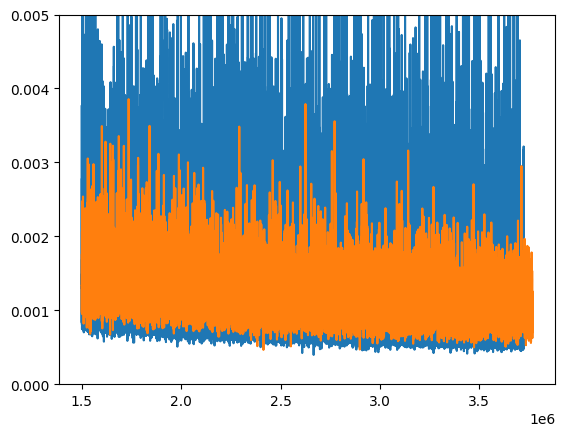

In [100]:
start = 1500000
smooth = 1

x = np.arange(len(losses)/smooth)
y = torch.tensor(losses).view(smooth, -1).mean(0)
plt.plot(x[start:], y[start:])

e_x = np.arange(0, (len(eval_losses)/smooth) * 100, 100)
e_y = torch.tensor(eval_losses).view(smooth, -1).mean(0)
plt.plot(e_x[int(start/100):], e_y[int(start/100):])

plt.ylim(0, 0.005)
plt.show()

In [58]:
def evaluation(fen):
    model.eval()
    score  = model(fen_to_bitboard(fen).to(device))
    model.train()
    return score.item()

In [127]:
def minimax(board, depth):
    moves = list(board.legal_moves)
    if depth == 0:
        score = evaluation(board.fen())
        if board.turn == chess.WHITE:
            return score, None
        else:
            return score, None
    if board.turn == chess.WHITE:
        maxScore = -100
        best_move = None
        for m in moves:
            board.push(m)
            score, _ = minimax(board, depth-1)
            if score > maxScore:
                maxScore = score
                best_move = m
            board.pop()
        if depth < 3:
            return maxScore, None
        if depth == 3:
            return maxScore, best_move
    else:
        minScore = 100
        best_move = None
        for m in moves:
            board.push(m)
            score, _ = minimax(board, depth-1)
            if score < minScore:
                minScore = score
                best_move = m
            board.pop()
        if depth < 3:
            return minScore, None
        if depth == 3:
            return minScore, best_move

In [187]:
class node():
    def __init__(self, fen, parent, color):
        self.fen = fen
        self.parent = parent
        self.children = None
        self.visits = 1
        self.wins = evaluation(fen)
        self.color = color

In [249]:
def search(board):
    tree = []
    root = node(board.fen(), None, board.turn)
    tree.append(root)
    for w in range(1000):
        # selection
        # need to get a leaf node first, traverse downward
        current = tree[0]
        while current.children is not None:
            best = -100
            best_node = None
            for c in current.children:
                b = (c.wins / c.visits) + np.sqrt(2) * np.sqrt(np.log(c.parent.visits) / c.visits) 
                if b > best:
                    best = b
                    best_node = c
            current = best_node
            
        
        # expanding out all possible moves
        moves = []
        board.set_fen(current.fen)
        for m in list(board.legal_moves):
            board.push(m)
            n = node(board.fen(), current, board.turn)
            moves.append(n)
            tree.append(n)
            board.pop()
        current.children = moves
        
        # back propogation
        for n in current.children:
            score = n.wins
            color = n.color
            temp = n.parent
            
            while temp is not None:
                temp.visits += 1
                if color == current.color:
                    temp.wins += score
                else:
                    temp.wins += (1 - score)
                temp = temp.parent
                    
    # get best node
    tree.remove(root)
    most_visits = 0
    best_move = None
    for t in tree:
        if t.visits > most_visits:
            most_visits = t.visits
            best_move = t.fen
    return best_move, most_visits
            
        

In [251]:
fen = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1"
board = chess.Board(fen)
# print(minimax(board, 3))
search(board)

('rnbqkbnr/pppppppp/8/8/6P1/8/PPPPPP1P/RNBQKBNR b KQkq - 0 1', 2136)

In [142]:
fen = "2kr3r/1pp1pp1p/p6n/5q2/3bN1p1/3P1P2/PP3RPP/R1BQ2K1 b - - 0 16"
board = chess.Board(fen)
moves = list(board.legal_moves)

best_score = -1000
best_move = ""
for m in moves:
    board.push(m)
    score = evaluation(board.fen())
    print(str(score) + " " + str(m))
    if score > best_score:
        best_score = score
        best_move = m
    board.pop()
print(best_move)

0.1117396354675293 h8g8
0.09882411360740662 h8f8
0.07409432530403137 h8e8
0.15446767210960388 d8g8
0.12033817172050476 d8f8
0.07037353515625 d8e8
0.13731563091278076 d8d7
0.20376084744930267 d8d6
0.0869358479976654 d8d5
0.07554253935813904 c8b8
0.10079485177993774 c8d7
0.09480690956115723 h6g8
0.10955634713172913 f5d7
0.0006942152976989746 f5g6
0.08554428815841675 f5f6
0.06046062707901001 f5e6
0.08908319473266602 f5h5
0.10336443781852722 f5g5
0.19712936878204346 f5e5
0.06519752740859985 f5d5
0.09792423248291016 f5c5
0.04803466796875 f5b5
0.06548139452934265 f5a5
0.13746583461761475 f5f4
0.005296438932418823 f5e4
0.11470183730125427 f5f3
0.18837203085422516 d4g7
0.16175910830497742 d4f6
0.07576242089271545 d4b6
0.148159921169281 d4e5
0.08390054106712341 d4c5
0.18294283747673035 d4e3
0.543045163154602 d4c3
0.0833069384098053 d4f2
0.09695187211036682 d4b2
0.17273756861686707 g4f3
0.06479686498641968 f7f6
0.047541290521621704 e7e6
0.054818421602249146 c7c6
0.05162116885185242 b7b6
0.068109